# Case study: re-analysis of frog (*Xenopus tropicalis*) embryogenesis single-cell data

This notebook will demonstrate scRNA-seq processing with orthomap using frog scRNA data from ([Briggs et al. 2018](https://doi.org/10.1126/science.aar5780); [Qiu et al., 2022](https://doi.org/10.1038/s41588-022-01018-x)).

scRNA data were obtained from http://tome.gs.washington.edu/, converted into Scanpy `AnnData` objects ([Wolf et al., 2018](https://doi.org/10.1186/s13059-017-1382-0)) and are availabe here:

https://zenodo.org/record/7244441

or can be accessed with the `dataset` submodule of `orthomap`

`datasets.qiu22_frog(datapath='data')` (download folder set to `'data'`).

## Notebook file

Notebook file can be obtained here:

[https://raw.githubusercontent.com/kullrich/orthomap/main/docs/notebooks/frog_example.ipynb](https://raw.githubusercontent.com/kullrich/orthomap/main/docs/notebooks/frog_example.ipynb)

## Steps

To process the scRNA data, we will do the following:

0. Run OrthoFinder to obtain orthogroups
1. Get query species taxonomic lineage information
2. Get query species orthomap
3. Map OrthoFinder gene names and scRNA gene/transcript names
4. Get TEI values and add them to scRNA dataset
5. Get partial TEI values to visualize gene age class contributions
6. Process scRNA data and visualize TEI

## Import libraries

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt
from statannot import add_stat_annotation
# increase dpi
%matplotlib inline
#plt.rcParams['figure.dpi'] = 300
#plt.rcParams['savefig.dpi'] = 300
plt.rcParams['figure.figsize'] = [6, 4.5]
#plt.rcParams['figure.figsize'] = [4.4, 3.3]

## Import orthomap python package submodules

In [2]:
# import submodules
from orthomap import qlin, gtf2t2g, of2orthomap, orthomap2tei, datasets

## Step 0 - run OrthoFinder to obtain orthogroups

`orthomap` can extract gene age classification from existing OrthoFinder results and link them with scRNA data.

A detailed how-to is available here:

https://orthomap.readthedocs.io/en/latest/tutorials/orthofinder.html

However, any pre-calculated gene age classification can be imported as a table using the function `orthomap2tei.read_orthomap(orthomapfile=filename)`.

The pre-calculated gene age classification file should be <tab> delimited with two columns `GeneID<tab>Phylostratum`, like e.g.:
    
```
GeneID<tab>Phylostratum
WBGene00000001<tab>1
WBGene00000002<tab>1
WBGene00000003<tab>1
WBGene00000004<tab>1
WBGene00000005<tab>2
```

OrthoFinder ([Emms and Kelly, 2019](https://doi.org/10.1186/s13059-019-1832-y)) results (-S last) using translated, longest-isoform coding sequences (CDS) from [Ensembl release-110](https://ftp.ensembl.org/pub/release-110/), including species taxonomic IDs, are available here: 

https://doi.org/10.5281/zenodo.7242264

or can be accessed with the `dataset` submodule of `orthomap`

`datasets.ensembl110_last(datapath='data')` (download folder set to `'data'`).

To be able to process the scRNA data from [Briggs et al. 2018](https://doi.org/10.1126/science.aar5780) the OrthoFinder run for [Ensembl release-110](https://ftp.ensembl.org/pub/release-110/) was supplemented with the gene models of *X. tropicalis* v9.0 [https://ftp.xenbase.org/pub/Genomics/JGI/Xentr9.0/Xtropicalisv9.0.Named.primaryTrs.pep.fa.gz](https://ftp.xenbase.org/pub/Genomics/JGI/Xentr9.0/Xtropicalisv9.0.Named.primaryTrs.pep.fa.gz).

This use case show that with OrthoFinder it is possible to add any new annotation as a new entry and use it with orthomap to extract the correspoding gene age assignments.

In [3]:
datasets.ensembl110_last(datapath='data')

100% [..............................................................................] 11317 / 11317

['data/ensembl_110_orthofinder_last_Orthogroups.GeneCount.tsv.zip',
 'data/ensembl_110_orthofinder_last_Orthogroups.tsv.zip',
 'data/ensembl_110_orthofinder_last_species_list.tsv']

## Step 1 - get query species taxonomic lineage information

Given a species name or taxonomic ID, the query species lineage information is extracted with the help of the `ete3` python toolkit and the `NCBI taxonomy` ([Huerta-Cepas et al., 2016](https://doi.org/10.1093/molbev/msw046)). This information is needed alongside with the taxonomic classifications for all species used in the OrthoFinder comparison.

The `orthomap` submodule `qlin` helps to get this information for you with the `qlin.get_qlin()` function as follows:

In [4]:
# get query species taxonomic lineage information
query_lineage = qlin.get_qlin(q='Xenopus tropicalis')

query name: Xenopus tropicalis
query taxID: 8364
query kingdom: Eukaryota
query lineage names: 
['root(1)', 'cellular organisms(131567)', 'Eukaryota(2759)', 'Opisthokonta(33154)', 'Metazoa(33208)', 'Eumetazoa(6072)', 'Bilateria(33213)', 'Deuterostomia(33511)', 'Chordata(7711)', 'Craniata(89593)', 'Vertebrata(7742)', 'Gnathostomata(7776)', 'Teleostomi(117570)', 'Euteleostomi(117571)', 'Sarcopterygii(8287)', 'Dipnotetrapodomorpha(1338369)', 'Tetrapoda(32523)', 'Amphibia(8292)', 'Batrachia(41666)', 'Anura(8342)', 'Pipoidea(30319)', 'Pipidae(8352)', 'Xenopodinae(8360)', 'Xenopus(8353)', 'Silurana(8363)', 'Xenopus tropicalis(8364)']
query lineage: 
[1, 131567, 2759, 33154, 33208, 6072, 33213, 33511, 7711, 89593, 7742, 7776, 117570, 117571, 8287, 1338369, 32523, 8292, 41666, 8342, 30319, 8352, 8360, 8353, 8363, 8364]


## Step 2 - gene age class assignment (query species orthomap)

Here, `orthomap` use the query species information and OrthoFinder results to extract the oldest common tree node per orthogroup along a species tree and to assign this node as the gene age to the corresponding genes.

In a pairwise manner, the query species and any other species in the OrthoFinder result might share multiple tree nodes down to the root of the species tree, but have only one youngest tree node in common. Among all possible comparison between the query species and the other species, the oldest as defined by the species tree root is seected and used for the gene age assignment.

Given the `query species sequence name` (`seqname=`) used in the OrthoFinder comparison, the `query species taxonomic ID`(`qt=`), the `taxonomic IDs of all species` (`sl=`) used in the OrthoFinder comparison, the `orthogroup gene count` (`oc=`) results and the `orthogroups` (`og=`), an orthomap is constructed.

__Note:__ This step can take up to five minutes, depending on your hardware.

For this step to get the query species orthomap, one uses the `of2orthomap.get_orthomap()` function, like:

In [5]:
# get query species orthomap

# download orthofinder results here: https://doi.org/10.5281/zenodo.7242264
# or download with datasets.ensembl110_last('data')
query_orthomap, orthofinder_species_list, of_species_abundance = of2orthomap.get_orthomap(
    seqname='Xtropicalisv9.0.Named.primaryTrs.pep',
    qt='8364',
    sl='data/ensembl_110_orthofinder_last_species_list.tsv',
    oc='data/ensembl_110_orthofinder_last_Orthogroups.GeneCount.tsv.zip',
    og='data/ensembl_110_orthofinder_last_Orthogroups.tsv.zip',
    continuity=True)
query_orthomap

Xtropicalisv9.0.Named.primaryTrs.pep
Xenopus tropicalis
8364
                                    species  taxID  \
0                 10020.dipodomys_ordii.pep  10020   
1    10029.cricetulus_griseus_chok1gshd.pep  10029   
2       10029.cricetulus_griseus_crigri.pep  10029   
3         10029.cricetulus_griseus_picr.pep  10029   
4            10036.mesocricetus_auratus.pep  10036   
..                                      ...    ...   
313          9986.oryctolagus_cuniculus.pep   9986   
314        99883.tetraodon_nigroviridis.pep  99883   
315        9994.marmota_marmota_marmota.pep   9994   
316            9999.urocitellus_parryii.pep   9999   
317    Xtropicalisv9.0.Named.primaryTrs.pep   8364   

                                               lineage  youngest_common  \
0    [1, 131567, 2759, 33154, 33208, 6072, 33213, 3...            32523   
1    [1, 131567, 2759, 33154, 33208, 6072, 33213, 3...            32523   
2    [1, 131567, 2759, 33154, 33208, 6072, 33213, 3...           

seqID Orthogroup  PSnum PStaxID              PSname  \
0         LOC100485125  OG0000000      6   33213           Bilateria   
1         LOC100485127  OG0000000      6   33213           Bilateria   
2         LOC100485283  OG0000000      6   33213           Bilateria   
3         LOC100485369  OG0000000      6   33213           Bilateria   
4         LOC100485372  OG0000000      6   33213           Bilateria   
...                ...        ...    ...     ...                 ...   
24019  Xetrov90018953m  OG0037628     25    8364  Xenopus tropicalis   
24020  Xetrov90028748m  OG0037629     25    8364  Xenopus tropicalis   
24021  Xetrov90028749m  OG0037629     25    8364  Xenopus tropicalis   
24022  Xetrov90030626m  OG0037630     25    8364  Xenopus tropicalis   
24023  Xetrov90030627m  OG0037630     25    8364  Xenopus tropicalis   

       PScontinuity  
0          0.777778  
1          0.777778  
2          0.777778  
3          0.777778  
4          0.777778  
...             ...  
24019      1.000000  
24020      1.000000  
24021      1.000000  
24022      1.000000  
24023      1.000000  

[24024 rows x 6 columns]

### Gene age assignments per query species lineage node

Given an orthomap, one can get an overview of the gene age assignments per query species lineage node.

The `orthomap` submodule `of2orhomap` and the `of2orthomap.get_counts_per_ps()` function will show the distribution of the gene age classes and can be further visualized as follows:

In [6]:
# show count per taxonomic group (PStaxID)
of2orthomap.get_counts_per_ps(query_orthomap)

PSnum  counts PStaxID              PSname
PSnum                                           
3          3    3912   33154        Opisthokonta
6          6    9106   33213           Bilateria
8          8    2399    7711            Chordata
10        10    2325    7742          Vertebrata
11        11    1532    7776       Gnathostomata
13        13     783  117571        Euteleostomi
14        14      51    8287       Sarcopterygii
16        16     260   32523           Tetrapoda
19        19     403    8342               Anura
25        25    3253    8364  Xenopus tropicalis

### Visualize number of species along query lineage and counts per gene age class

<AxesSubplot: >

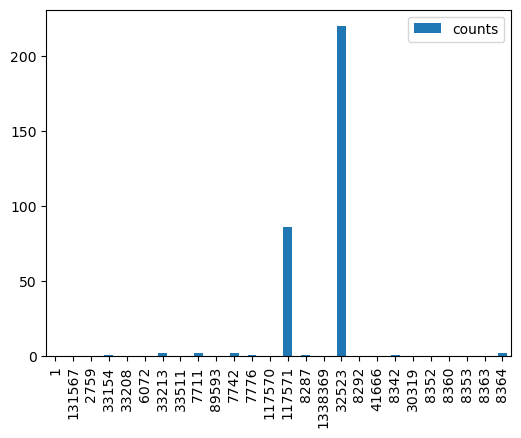

In [7]:
# show number of species along query lineage
of_species_abundance

# bar plot number of species along query lineage
of_species_abundance.plot.bar(y='counts', use_index=True)

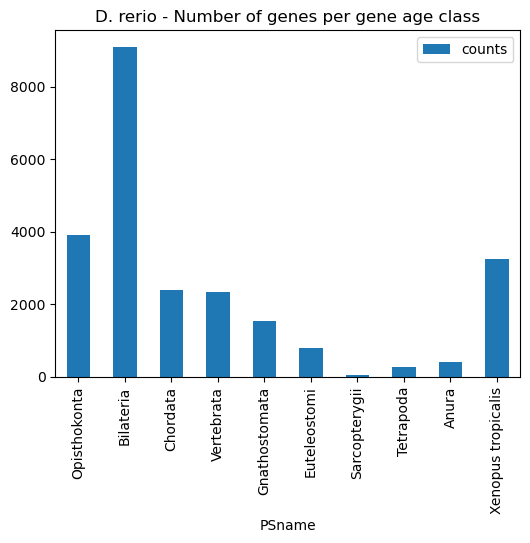

In [8]:
# show count per taxonomic group (PStaxID)
of2orthomap.get_counts_per_ps(query_orthomap)

# bar plot count per taxonomic group (PSname)
ax = of2orthomap.get_counts_per_ps(query_orthomap).plot.bar(y='counts', x='PSname')
ax.set_title('D. rerio - Number of genes per gene age class')
plt.show()

## Step 3 - map OrthoFinder gene names and scRNA gene/transcript names

To be able to link gene ages assignments from an orthomap and gene or transcript of scRNA dataset, one needs to check the overlap of the annotated gene names. With the `gtf2t2g` submodule of `orthomap` and the `gtf2t2g.parse_gtf()` function, one can extract gene and transcript names from a given gene feature file (`GTF`).

Here, the gene models from *X. tropicalis* v9.0 were used and gene names already should overlap with the orthomap gene names ([Briggs et al. 2018](https://doi.org/10.1126/science.aar5780); [https://ftp.xenbase.org/pub/Genomics/JGI/Xentr9.0/Xtropicalisv9.0.Named.primaryTrs.pep.fa.gz](https://ftp.xenbase.org/pub/Genomics/JGI/Xentr9.0/Xtropicalisv9.0.Named.primaryTrs.pep.fa.gz)).

If in your case gene or transcript IDs between an orthomap and scRNA data do not match directly, please have a look at a detailed how-to to match them:

https://orthomap.readthedocs.io/en/latest/tutorials/geneset_overlap.html

### Import now, the scRNA dataset of the query species

Here, data is used, like in the publication ([Briggs et al. 2018](https://doi.org/10.1126/science.aar5780); [Qiu et al., 2022](https://doi.org/10.1038/s41588-022-01018-x)).

scRNA data was downloaded from http://tome.gs.washington.edu/ as R rds files, combined into a single Seurat object and converted into loom and AnnData (h5ad) files to be able to analyse with e.g. python scanpy or orthomap package and is available here:

https://doi.org/10.5281/zenodo.7244440

or can be accessed with the `dataset` submodule of `orthomap`:

`datasets.qiu22_frog(datapath='data')` (download folder set to `'data'`).

In [9]:
# load scRNA data

# download zebrafish scRNA data here: https://doi.org/10.5281/zenodo.7244440
# or download with datasets.qui22_frog(datapath='data')

#frog_data = datasets.qiu22_zebrafish(datapath='data')
frog_data = sc.read('data/frog_data.h5ad')

### Get an overview of observations

In [10]:
frog_data

AnnData object with n_obs × n_vars = 123633 × 26550
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'sample', 'stage', 'group', 'cell_state', 'cell_type'
    var: 'features', 'genes'

In [11]:
frog_data.obs

orig.ident  nCount_RNA  nFeature_RNA       sample stage  \
S8_cell_1             cell     20658.0          5506       cell_1    S8   
S8_cell_2             cell     17002.0          5209       cell_2    S8   
S8_cell_3             cell     16190.0          4880       cell_3    S8   
S8_cell_4             cell     15652.0          4930       cell_4    S8   
S8_cell_5             cell     14325.0          4598       cell_5    S8   
...                    ...         ...           ...          ...   ...   
S22_cell_136962       cell      1809.0           721  cell_136962   S22   
S22_cell_136963       cell      1575.0           789  cell_136963   S22   
S22_cell_136964       cell      1393.0           677  cell_136964   S22   
S22_cell_136965       cell      1193.0           603  cell_136965   S22   
S22_cell_136966       cell       811.0           516  cell_136966   S22   

                    group                         cell_state  \
S8_cell_1        Clutch_1                        S8:blastula   
S8_cell_2        Clutch_1                        S8:blastula   
S8_cell_3        Clutch_1                        S8:blastula   
S8_cell_4        Clutch_1                        S8:blastula   
S8_cell_5        Clutch_1                        S8:blastula   
...                   ...                                ...   
S22_cell_136962  Clutch_6                         S22:somite   
S22_cell_136963  Clutch_6                         S22:somite   
S22_cell_136964  Clutch_6  S22:intermediate mesoderm (ssg1+)   
S22_cell_136965  Clutch_6                    S22:spinal cord   
S22_cell_136966  Clutch_6            S22:presomitic mesoderm   

                                     cell_type  
S8_cell_1                             blastula  
S8_cell_2                             blastula  
S8_cell_3                             blastula  
S8_cell_4                             blastula  
S8_cell_5                             blastula  
...                                        ...  
S22_cell_136962                         somite  
S22_cell_136963                         somite  
S22_cell_136964  intermediate mesoderm (ssg1+)  
S22_cell_136965                    spinal cord  
S22_cell_136966            presomitic mesoderm  

[123633 rows x 8 columns]

### Helper functions to match gene names

The `orthomap2tei` submodule contains the `orthomap2tei.geneset_overlap()` helper function to check for gene name overlap between the constructed orthomap from `OrthoFinder` results and a given scRNA dataset.

In [12]:
# check overlap of orthomap <seqID> and scRNA data <var_names>
orthomap2tei.geneset_overlap(frog_data.var_names, query_orthomap['seqID'])

g1_g2_overlap  g1_ratio  g2_ratio
0          24023  0.904821  0.999958

## Step 4 - Get TEI values and add them to scRNA dataset

Since now the gene names correspond to each other in the orthomap and the scRNA `adata` object, one can calculate the transcriptome evolutionary index (`TEI`) and add them to the scRNA dataset (`adata` object).

The `TEI` measure represents the weighted arithmetic mean (expression levels as weights for the phylostratum value) over all evolutionary age categories denoted as _phylostra_.

${TEI_s = \sum (e_is * ps_i) / \sum e_is}$

, where ${TEI_s}$ denotes the `TEI` value in developmental stage ${s, e_is}$ denotes the gene expression level of gene ${i}$ in stage ${s}$, and ${ps_i}$ denotes the corresponding phylostratum of gene ${i, i = 1,...,N}$ and ${N = total\ number\ of\ genes}$.

Note: If e.g. two different isoforms would fall into two different gene age classes, their gene ages might differ based on the oldest ortholog found in their corresponding orthologous groups. However, both isoforms share the same gene name and their gene ages would clash. In this case one can decide either to use the `keep='min'` or `keep='max'` gene age to be kept by the `get_tei` function, which defaults to keep in this cases the `keep='min'` or in other words the 'older' gene age.

To be able to re-use the original `count` data, they are added as a new `layer` to the `adata` object. This is useful because later on the `count` data can be used to extract either the relative expression per gene age class or re-calculate other metrics. 

This can be done either on un-normalized `counts`, on `normalized` and `log-transformed` data.

In [13]:
frog_data.layers['counts'] = frog_data.X

### add TEI to adata object

Using the submodule `orthomap2tei` from `orthomap` and the `orthomap2tei.get_tei()` function, transcriptome evolutionary index (`TEI`) values are calculated and directyl added to the existing `adata` object (`add_obs=True`).

There are other options to e.g. not start from the `adata.X` `counts` but from another `layer` from the `adata` object, the default is to use the `adata.X` (`layer=None`). The values can be pre-processed by the `normalize_total` option and the `log1p` option.

If `add_obs=True` the resulting `TEI` values are added to the existing `adata` object as a new observation with the name set with the `obs_name` option.

If `add_var=True` the gene age values are added to the existing `adata` object as a new variable with the name set with the `var_name` option.

__Note:__ Genes not assigned to any gene class will get a missing assignment.

If one wants to calculate bootstrap `TEI` values per cell, the `boot` option can be set to `boot=True` and gene age classes will be randomly chosen prior calculating `TEI` values `bt=10` times.

In [14]:
# add TEI values to existing adata object
orthomap2tei.get_tei(adata=frog_data,
    gene_id=query_orthomap['seqID'],
    gene_age=query_orthomap['PSnum'],
    keep='min',
    layer=None,
    add_var=True,
    var_name='Phylostrata',
    add_obs=True,
    obs_name='tei',
    boot=False,
    bt=10,
    normalize_total=True,
    log1p=True,
    target_sum=1e6)

tei
S8_cell_1        6.149558
S8_cell_2        6.158777
S8_cell_3        6.179419
S8_cell_4        6.107512
S8_cell_5        6.119982
...                   ...
S22_cell_136962  5.089091
S22_cell_136963  5.087404
S22_cell_136964  5.009514
S22_cell_136965  5.155880
S22_cell_136966  5.133554

[123633 rows x 1 columns]

## Step 5 - downstream analysis

Once the gene age data has been added to the scRNA dataset, one can e.g. plot the corresponding transcriptome evolutionary index (`TEI`) values by any given observation pre-defined in the scRNA dataset.

Here, we plot them against the assigned embryo stage and against assigned cell types of the zebrafish using the `scanpy` `sc.pl.violin()` function as follows:

### Boxplot gene age class per sample timepoint

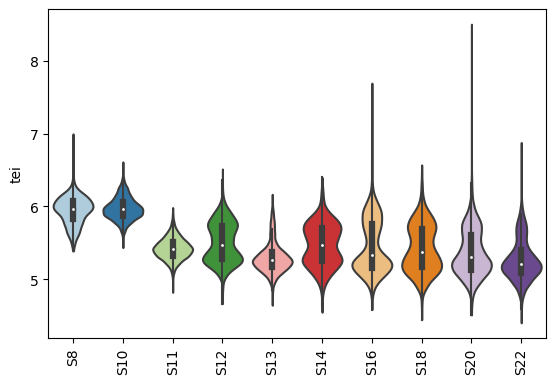

In [15]:
sc.pl.violin(adata=frog_data,
             keys=['tei'],
             groupby='stage',
             rotation=90,
             palette='Paired',
             stripplot=False,
             inner='box')

To alter ylim do:

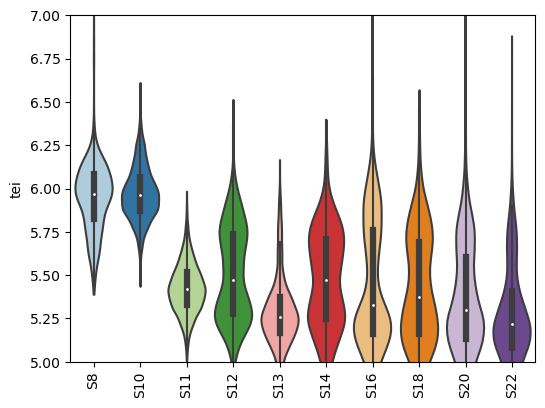

In [16]:
fig, ax = plt.subplots()
sc.pl.violin(adata=frog_data,
             keys=['tei'],
             groupby='stage',
             rotation=90,
             palette='Paired',
             stripplot=False,
             inner='box',
             ax=ax,
             show=False)
ax.set_ylim(5, 7)
plt.show()

### Boxplot gene age class per embryo stage and per cell type

E.g. to just show the same plot for a selected cell-type, one could do the following.

1. List all annotated cell types:

In [17]:
list(set(frog_data.obs['cell_type']))

['optic neuron',
 'involuted ventral mesoderm',
 'epibranchial and lateral line placode',
 'cement gland primordium',
 'lens placode',
 'hatching gland',
 'dorsal marginal zone',
 'neural plate anterior (fezf1+)',
 'pronephric mesenchyme',
 'otic placode',
 'blood',
 'placodal area',
 'ionocyte',
 'hindbrain',
 'anterior placodal area',
 'ciliated epidermal progenitor',
 'adenohypophyseal placode',
 'ectoderm',
 'neuroectoderm',
 'somite',
 'ventral blood island',
 'optic vesicle',
 'spinal cord',
 'chordal neural crest',
 'tail bud',
 'placodal neuron',
 'posterior placodal area',
 'surface ectoderm',
 'notochord',
 'germ cell',
 'endoderm',
 'blastula',
 'lateral plate mesoderm',
 'cranial neural crest',
 'goblet cell',
 'chordal neural plate border',
 'gut',
 'dorsal lateral plate region',
 'small secretory cells',
 'intermediate mesoderm (ssg1+)',
 'cardiac mesoderm',
 'early neuron',
 'eye primordium',
 'notoplate',
 'neuroendocrine cell',
 'alpha ionocyte',
 'beta ionocyte',
 'Ro

2. Loop over all cell types:

__Note:__ Please change notebook cell from `raw` to `code` to see the plots.

### Plot relative expression per gene age class per sample stage

In [18]:
frog_data_rematrix_grouped = orthomap2tei.get_rematrix(
    adata=frog_data,
    gene_id=query_orthomap['seqID'],
    gene_age=query_orthomap['PSnum'],
    keep='min',
    layer=None,
    use='counts',
    var_type='mean',
    group_by_obs='stage',
    obs_fillna='__NaN',
    obs_type='mean',
    standard_scale=0,
    normalize_total=True,
    log1p=True,
    target_sum=1e6)
frog_data_rematrix_grouped

stage        S8  S10       S11       S12       S13       S14       S16  \
ps                                                                       
3      0.549148  1.0  0.000000  0.481208  0.030958  0.635034  0.540971   
6      0.640801  1.0  0.025922  0.391773  0.000000  0.487045  0.373626   
8      0.693043  1.0  0.002146  0.335158  0.000000  0.435697  0.330510   
10     0.657684  1.0  0.027835  0.361469  0.000000  0.432258  0.345035   
11     0.689678  1.0  0.038879  0.349611  0.000000  0.414623  0.330977   
13     0.630477  1.0  0.000000  0.371492  0.034908  0.480240  0.422663   
14     0.628787  1.0  0.000000  0.340251  0.010592  0.440440  0.357441   
16     0.732670  1.0  0.069467  0.376976  0.000000  0.391185  0.345026   
19     0.744651  1.0  0.019259  0.305098  0.000000  0.346719  0.322236   
25     0.617543  1.0  0.051890  0.340161  0.000000  0.351700  0.348766   

stage       S18       S20       S22  
ps                                   
3      0.566287  0.556049  0.540787  
6      0.408093  0.369463  0.314640  
8      0.351909  0.314005  0.234338  
10     0.345311  0.302562  0.223977  
11     0.351258  0.302937  0.232756  
13     0.412788  0.373843  0.281930  
14     0.351782  0.298162  0.220355  
16     0.326862  0.281135  0.208118  
19     0.298132  0.248512  0.174518  
25     0.279890  0.253492  0.171583

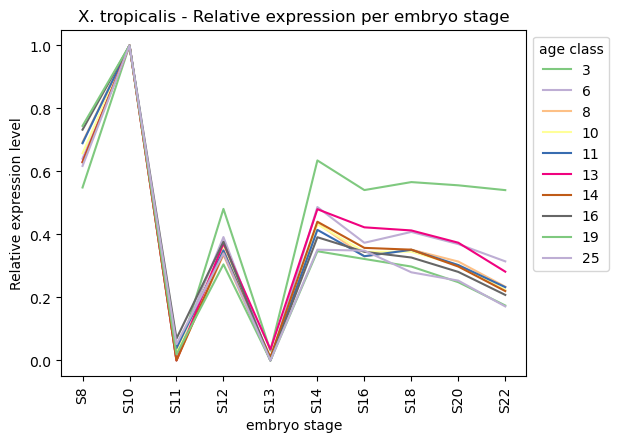

In [19]:
ax = sns.lineplot(frog_data_rematrix_grouped.transpose(), palette='Accent', dashes=False)
ax.legend(fontsize=5, title='age class')
ax.set_title('X. tropicalis - Relative expression per embryo stage')
ax.set_xlabel('embryo stage')
ax.set_ylabel('Relative expression level')
sns.move_legend(ax, 'upper left', bbox_to_anchor=(1, 1))
#plt.tick_params(labelsize=3)
plt.xticks(rotation=90)
plt.show()

### Get partial TEI values to visualize gene age class contributions

Partial `TEI` values can give an idea about which gene age class contributed at most to the `global` `TEI` pattern.

In detail, each gene gets a `TEI` contribution profile as follows:

${TEI_is = f_is * ps_i}$

, where ${TEI_is}$ is the partial `TEI` value of gene ${i}$, ${f_is = e_is / \sum e_is}$ and ${ps_i}$ is the phylostratum of gene i.

${TEI_is}$ values are combined per ${ps}$.

The partial `TEI` values combined per strata give an overall impression of the contribution of each strata to the `global` `TEI` pattern.

One can either start from `counts` (`adata.X`) which is set as default or any other `layer` defined by the `layer` option (`layer=None`).

In addition, the `counts` can be `normalized` and `log-transformed` prior calculating partial `TEI` values (`normalize_total=False`, `log1p=False`, `target_sum=1e6`).

Further, these values can be combined per given observation, e.g. cell typer per sample timepoint (`group_by='cell_state'`).

The `get_pstrata` function of the `orthomap2tei` submodule will return two matrix, the first contains the sum of each partial `TEI` per gene age class and the second the corresponding frequencies.

Both can be further processed by returning the `cumsum` over the gene age classes. To get them set the option `cumsum=True`. The `cumsum` will result in either for the first matrix the `TEI` value per cell or mean `TEI` value per group, if one choose a observation with the `group_by` option. Or in case of the second frequency matrix will result in 1.

With the `standard_scale` option either gene age classes (`standard_scale=0` rows) or cells or groups (`standard_scale=1` columns) can be scaled, subtract the minimum and divide each by its maximum. By default no scaling is applied (`standard_scale=None`).

The resulting data will be visualized in the downstream section.

In [20]:
frog_pstrata = orthomap2tei.get_pstrata(adata=frog_data,
    gene_id=query_orthomap['seqID'],
    gene_age=query_orthomap['PSnum'],
    keep='min',
    layer=None,
    cumsum=False,
    group_by_obs='stage',
    obs_fillna='__NaN',
    obs_type='mean',
    standard_scale=None,
    normalize_total=True,
    log1p=True,
    target_sum=1e6)
frog_pstrata[0]

stage        S8       S10       S11       S12       S13       S14       S16  \
ps                                                                            
3      1.065076  1.075439  1.297339  1.278294  1.372506  1.296431  1.327240   
6      2.622632  2.599675  2.466392  2.450787  2.355235  2.416976  2.374067   
8      0.592121  0.570923  0.447412  0.467962  0.450746  0.474230  0.458361   
10     0.727489  0.734946  0.610400  0.621289  0.576776  0.610543  0.597909   
11     0.302491  0.302306  0.194769  0.214507  0.169287  0.215232  0.208144   
13     0.152253  0.160325  0.116740  0.133355  0.130488  0.140070  0.141939   
14     0.007637  0.008593  0.002546  0.004719  0.002786  0.005428  0.005013   
16     0.055560  0.053634  0.031272  0.037389  0.023350  0.033688  0.034344   
19     0.078653  0.074998  0.031865  0.041560  0.028736  0.041675  0.043754   
25     0.343420  0.391323  0.225555  0.254838  0.183497  0.241658  0.254372   

stage       S18       S20       S22  
ps                                   
3      1.321580  1.351918  1.398437  
6      2.394803  2.366329  2.330845  
8      0.464511  0.453797  0.426489  
10     0.588380  0.567627  0.537077  
11     0.213954  0.202081  0.189009  
13     0.137429  0.133691  0.125851  
14     0.004905  0.004333  0.003908  
16     0.032508  0.030156  0.027722  
19     0.040797  0.036679  0.032713  
25     0.222163  0.217640  0.194108

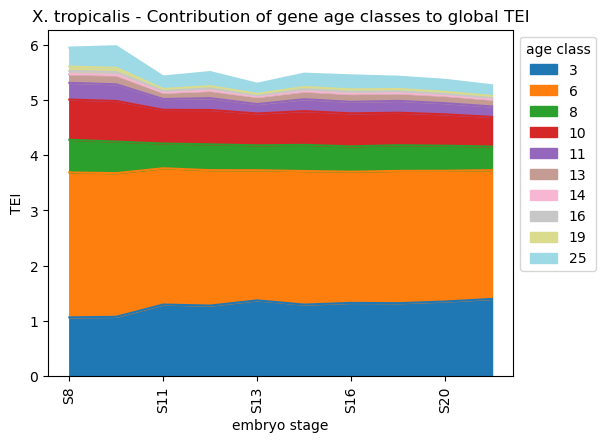

In [21]:
#plt.rcParams['figure.figsize'] = [9, 4.5]
ax=frog_pstrata[0].transpose().plot.area(cmap='tab20')
ax.legend(fontsize=3, title='age class')
ax.set_title('X. tropicalis - Contribution of gene age classes to global TEI')
ax.set_xlabel('embryo stage')
ax.set_ylabel('TEI')
sns.move_legend(ax, 'upper left', bbox_to_anchor=(1, 1))
plt.xticks(rotation=90)
plt.show()
#plt.rcParams['figure.figsize'] = [6, 4.5]

### Color UMAP/TSNE by TEI

Follwoing the basic tutorial of the Scanpy python toolkit ([Wolf et al., 2018](https://doi.org/10.1186/s13059-017-1382-0)), one can highlight `TEI` values on a dimensional reduction of the scRNA dataset, like `PCA`, `UMAP` or `TSNE`.

#### Filtering

In [22]:
sc.pp.filter_genes(frog_data, min_cells=3)
sc.pp.filter_cells(frog_data, min_genes=200)

#### Normalization, Log transformation and Scaling

In [23]:
sc.pp.normalize_total(frog_data, target_sum=1e6)
sc.pp.log1p(frog_data)
sc.pp.scale(frog_data, max_value=10)

#### PCA and Neighbor calculations

/opt/anaconda3/envs/scanpy/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


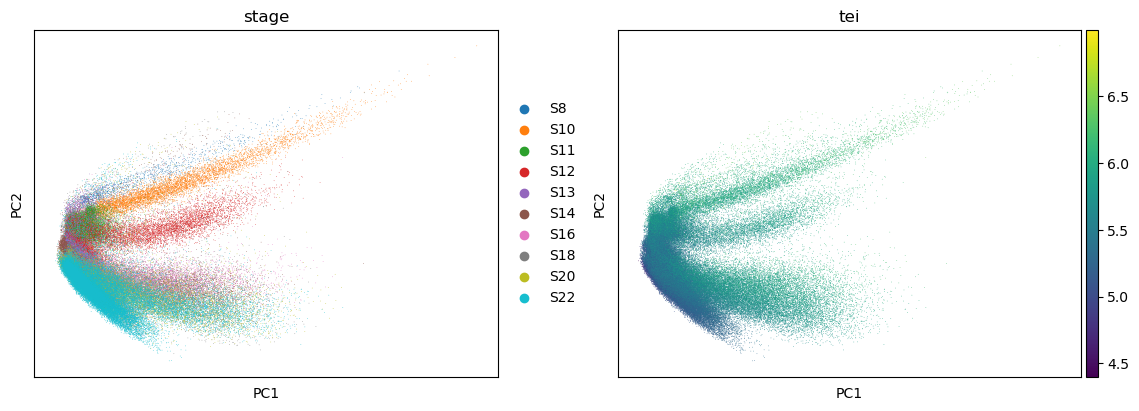

In [24]:
sc.tl.pca(frog_data, svd_solver='arpack')
sc.pl.pca(frog_data, color=['stage', 'tei'])

In [25]:
sc.pp.neighbors(frog_data)

#### Embedding the neighborhood graph

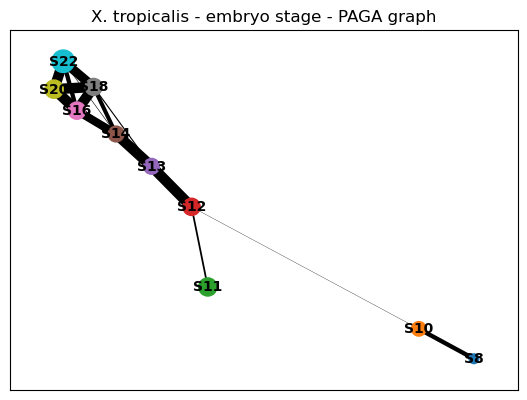

In [26]:
sc.tl.paga(frog_data, groups='stage')
sc.pl.paga(frog_data, title='X. tropicalis - embryo stage - PAGA graph')

#### UMAP

/opt/anaconda3/envs/scanpy/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


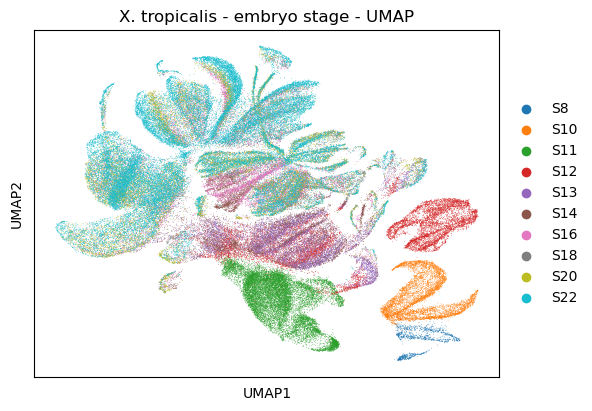

In [27]:
sc.tl.umap(frog_data,
           init_pos='paga')
sc.pl.umap(frog_data,
           title='X. tropicalis - embryo stage - UMAP', color=['stage'])

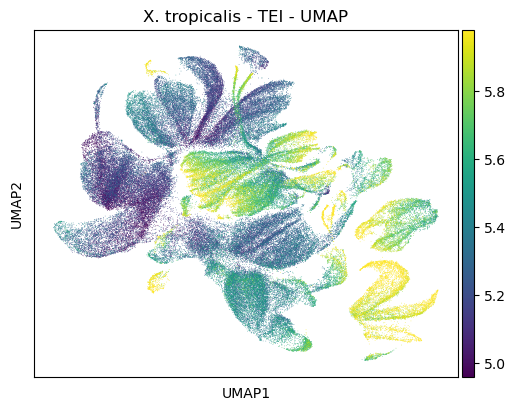

In [28]:
#plt.rcParams['figure.figsize'] = [7.5, 4.5]
sc.pl.umap(frog_data,
           title='X. tropicalis - TEI - UMAP',
           color=['tei'],
           color_map='viridis',
           vmin='p5',
           vmax='p95')
#plt.rcParams['figure.figsize'] = [6, 4.5]

/opt/anaconda3/envs/scanpy/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:325: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = ax.scatter(


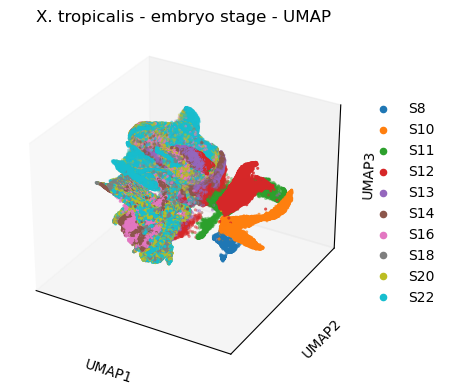

In [29]:
#3d
sc.tl.umap(frog_data,
           n_components=3)
sc.pl.umap(frog_data,
           title='X. tropicalis - embryo stage - UMAP', color=['stage'],
           projection='3d')

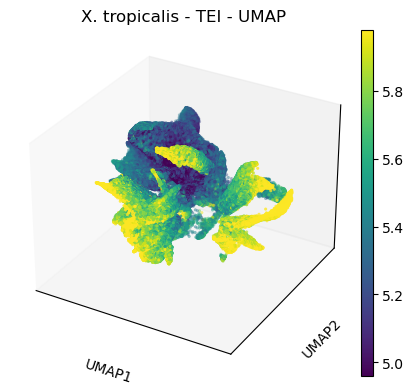

In [30]:
#plt.rcParams['figure.figsize'] = [7.5, 4.5]
sc.pl.umap(frog_data,
           title='X. tropicalis - TEI - UMAP',
           color=['tei'],
           color_map='viridis',
           vmin='p5',
           vmax='p95',
           projection='3d')
#plt.rcParams['figure.figsize'] = [6, 4.5]

In [31]:
import plotly
import kaleido
import plotly.express as px
plotly.offline.init_notebook_mode(connected=False)

In [32]:
frog_data

AnnData object with n_obs × n_vars = 123622 × 25544
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'sample', 'stage', 'group', 'cell_state', 'cell_type', 'tei', 'n_genes'
    var: 'features', 'genes', 'Phylostrata', 'n_cells', 'mean', 'std'
    uns: 'log1p', 'pca', 'stage_colors', 'neighbors', 'paga', 'stage_sizes', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'distances', 'connectivities'

In [33]:
df = pd.DataFrame( {'UMAP1':frog_data.obsm['X_umap'][:,0], 
                    'UMAP2':frog_data.obsm['X_umap'][:,1],
                    'UMAP3':frog_data.obsm['X_umap'][:,2],
                    'cell_type':frog_data.obs['cell_type'].values.astype(str),
                    'cell_state':frog_data.obs['cell_state'].values.astype(str),
                    'tei':frog_data.obs['tei'].values,
                    'stage':frog_data.obs['stage'].values,
                    'cell_id':frog_data.obs.index.to_list()  } ) 
df.set_index('cell_id', inplace = True)
df.head()

UMAP1     UMAP2     UMAP3 cell_type   cell_state       tei stage
cell_id                                                                       
S8_cell_1  7.549527  5.556860  1.716700  blastula  S8:blastula  6.149558    S8
S8_cell_2  7.573267  5.509485  1.777167  blastula  S8:blastula  6.158777    S8
S8_cell_3  7.555912  5.482943  1.783759  blastula  S8:blastula  6.179419    S8
S8_cell_4  7.496013  5.490688  1.724299  blastula  S8:blastula  6.107512    S8
S8_cell_5  7.656127  5.530446  1.815560  blastula  S8:blastula  6.119982    S8

In [34]:
fig = px.scatter_3d(data_frame = df,
                    x='UMAP1', 
                    y='UMAP2', 
                    z='UMAP3',
                    color='stage')
fig.update_traces(marker_size = 2)
fig.write_html('frog_scatter_3d_stage.html')

In [35]:
fig = px.scatter_3d(data_frame = df,
                    x='UMAP1', 
                    y='UMAP2', 
                    z='UMAP3',
                    color='tei',
                    range_color=(5,5.5))
fig.update_traces(marker_size = 2)
fig.write_html('frog_scatter_3d_tei.html')

In [36]:
fig = px.scatter_3d(data_frame = df,
                    x='UMAP1', 
                    y='UMAP2', 
                    z='UMAP3',
                    color='cell_type')
fig.update_traces(marker_size = 2)
fig.write_html('frog_scatter_3d_cell_type.html')

In [37]:
fig = px.scatter_3d(data_frame = df,
                    x='UMAP1', 
                    y='UMAP2', 
                    z='UMAP3',
                    color='cell_state')
fig.update_traces(marker_size = 2)
fig.write_html('frog_scatter_3d_cell_state.html')

Please have a look at the documentation for other [case studies](https://orthomap.readthedocs.io/en/latest/tutorials/index.html#case-studies).